In [78]:
import numpy as np
import pandas as pd
from phmd import datasets
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from scipy.stats import kurtosis
from scipy.fft import fft
from scipy.fft import fft, fftfreq
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
datasets.Dataset('PRONOSTIA').describe()

PRONOSTIA

Description
The IEEE PHM data challenge in 2012 utilized a renowned dataset provided by the FEMTO-ST Institute. The dataset originated from experiments conducted on a laboratory experimental platform known as PRONOSTIA, designed for accelerated degradation testing of bearings under various operating conditions. During these experiments, online health monitoring data including rotating speed, load force, temperature, and vibration were collected.

The dataset considered data from three different loads, encompassing rotating speed and load force variations. A total of 6 run-to-failure bearings were designated for building prognostic models, while an additional 11 bearings were allocated for testing purposes.

One notable characteristic of the challenge datasets was the relatively small amount of training data available, coupled with a high variability in experiment durations ranging from 1 to 7 hours. This variability posed a significant challenge in accurately estimating prog

In [3]:
ds = datasets.Dataset('PRONOSTIA')
task = ds['rul']
task.folds = 2
# for RUL task
task.normalize_output = True
# task.preprocess = MinMaxScaler()


In [104]:
def extract_features(h_signal, v_signal, unit,fs=25600):
    # Time-domain features
    features = {
        'h_RMS': np.sqrt(np.mean(h_signal**2)),
        'v_RMS': np.sqrt(np.mean(v_signal**2)),
        # 'h_Kurtosis': kurtosis(h_signal),
        # 'v_Kurtosis': kurtosis(v_signal),
        'h_Peak_to_Peak': np.max(h_signal) - np.min(h_signal),
        # 'RMS_Ratio': np.sqrt(np.mean(v_signal**2)) / np.sqrt(np.mean(h_signal**2)),
        'unit': unit,
    }

    # Cross-channel features
    cross_corr = np.correlate(h_signal, v_signal, mode='full')

    features.update({
        'max_cross_corr': np.max(cross_corr),
        'corr_lag': np.argmax(cross_corr) - len(h_signal)
    })

    h_n = len(h_signal)
    h_fft_vals = np.abs(fft(h_signal)[:h_n//2])
    h_freqs = fftfreq(h_n, 1/fs)[:h_n//2]

    features.update({
        'h_dom_freq': h_freqs[np.argmax(h_fft_vals)],
        'h_spectral_entropy': -np.sum(h_fft_vals * np.log(h_fft_vals + 1e-10)),
        'h_high_freq_energy': np.sum(h_fft_vals[h_freqs > 5000])  # 5kHz+ energy
    })

    v_n = len(v_signal)
    v_fft_vals = np.abs(fft(v_signal)[:v_n//2])
    v_freqs = fftfreq(v_n, 1/fs)[:v_n//2]

    features.update({
        'v_dom_freq': v_freqs[np.argmax(v_fft_vals)],
        'v_spectral_entropy': -np.sum(v_fft_vals * np.log(v_fft_vals + 1e-10)),
        'v_high_freq_energy': np.sum(v_fft_vals[v_freqs > 5000])  # 5kHz+ energy
    })
    
    # PROGNOSTIA bearing params (adjust for your dataset)
    rpm = 1800
    n_balls, ball_diam, pitch_diam = 8, 7.94e-3, 39e-3
    bpfo = (n_balls/2) * (1 - (ball_diam/pitch_diam)) * rpm/60  # ~100 Hz
    bsf = (pitch_diam/(2*ball_diam)) * (1 - (ball_diam/pitch_diam)**2) * rpm/60  # ~70 Hz
    
    # Energy near fault frequencies
    bpfo_energy = np.sum(h_fft_vals[(h_freqs >= bpfo-5) & (h_freqs <= bpfo+5)])
    bsf_energy = np.sum(h_fft_vals[(h_freqs >= bsf-5) & (h_freqs <= bsf+5)])

    features.update({
        'bpfo_energy': bpfo_energy,
        'bsf_energy':bsf_energy,
    })
    
    # Frequency-domain features (FFT)
    # n = len(h_signal)
    # h_fft = np.abs(fft(h_signal))[:n//2]
    # v_fft = np.abs(fft(v_signal))[:n//2]

    # freqs = np.linspace(0, fs/2, n//2)
    
    # features.update({
        # 'h_Dominant_Freq': freqs[np.argmax(h_fft)],
        # 'v_Dominant_Freq': freqs[np.argmax(v_fft)],
    # })
    
    return features

In [105]:
def get_postprocessed_data(X, window_size):
    features = []
    labels = []

    unit_dict = {}

    for unit, group in X.groupby('unit'):

        assert (group['rul'].diff().dropna() <= 0).all(), f"Non-monotonic RUL in {unit}"

        if unit in unit_dict:
            continue
        
        unit_dict[unit] = True

        for k in range(0, group.size - window_size, window_size // 2):
            if k + window_size > group['rul'].size:
                break

            h_window = group['H_acc'].values[k:k+window_size]
            v_window = group['V_acc'].values[k:k+window_size]

            # Extract features for the window
            features.append(extract_features(h_window, v_window, unit))

            # Assign the RUL label (last RUL value in the window)
            labels.append(group['rul'].iloc[k+window_size - 1])

    return features, labels


window_size = 25600

train_features = []
train_labels = []
test_features = []
test_labels = []

for i in range(task.folds):
    if i == 1:
        break

    data = task[i]

    X_train, X_val, X_test = data['train'], data['val'], data['test']
    X_train = pd.concat([X_train, X_val])
    X_train = X_train.reset_index().drop('index', axis=1)

    next_train_features, next_train_labels = get_postprocessed_data(X_train, window_size)
    next_test_features, next_test_labels = get_postprocessed_data(X_test, window_size)

    train_features += next_train_features
    train_labels += next_train_labels
    test_features += next_test_features
    test_labels += next_test_labels


Dataset PRONOSTIA already downloaded and extracted
Dataset PRONOSTIA already downloaded and extracted
Remember to cite the original publisher dataset:
	@inproceedings{nectoux2012pronostia,    
	    title={PRONOSTIA: An experimental platform for bearings accelerated degradation tests.},    
	    author={Nectoux, Patrick and Gouriveau, Rafael and Medjaher, Kamal and Ramasso, Emmanuel and Chebel-Morello, Brigitte and Zerhouni, Noureddine and Varnier, Christophe},    
	    booktitle={IEEE International Conference on Prognostics and Health Management, PHM'12.},    
	    pages={1--8},    
	    year={2012},    
	    organization={IEEE Catalog Number: CPF12PHM-CDR}    
	}
You can download the dataset manually from:  https://www.nasa.gov/intelligent-systems-division/discovery-and-systems-health/pcoe/pcoe-data-set-repository/

** If you find this tool useful, please cite our SoftwareX paper: 
	Solís-Martín, David, Juan Galán-Páez, and Joaquín Borrego-Díaz. "PHMD: An easy data access tool for pro

Reading Bearing3_3: 100%|██████████| 13959/13959 [01:05<00:00, 214.25it/s]
INFO:root:Read in 101.21413516998291 seconds
INFO:root:Read 3 sets: train,val,test
INFO:root:Columns: unit,H_acc,rul,V_acc
INFO:root:Train shape: (5880320, 4)
INFO:root:Val shape: (13406720, 4)
INFO:root:Test shape: (35735040, 4)


<Axes: >

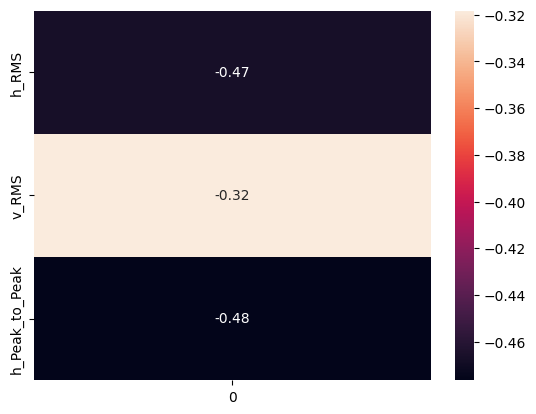

In [ ]:
# corr = pd.DataFrame(
#     pd.DataFrame(train_features)[['h_RMS', 'v_RMS', 'h_Peak_to_Peak']]
# ).corrwith(pd.Series(train_labels))
# sns.heatmap(corr.to_frame(), annot=True)

In [106]:
ohe = OneHotEncoder()

X_train = pd.DataFrame(train_features)
y_train = pd.DataFrame(train_labels, columns=['rul'])
X_train = pd.concat([
    X_train,
    y_train,
], axis=1).sort_values(by=['unit', 'rul'], ascending=[True, False])
train_units = X_train['unit'].values.reshape(-1, 1)
X_train_unit_features = ohe.fit_transform(train_units).toarray()
X_train_feature_names = ohe.get_feature_names_out()
X_train = pd.concat([
    X_train,
    pd.DataFrame(X_train_unit_features, columns=ohe.get_feature_names_out())
], axis=1)
X_train = X_train.drop('unit', axis=1)
y_train = np.array(X_train['rul'])
X_train = X_train.drop(['rul'], axis=1)

X_test = pd.DataFrame(test_features)
y_test = pd.DataFrame(test_labels, columns=['rul'])
X_test = pd.concat([
    X_test,
    y_test,
], axis=1).sort_values(by=['unit', 'rul'], ascending=[True, False])
test_units = X_test['unit'].values.reshape(-1, 1)
X_test_unit_features = ohe.fit_transform(test_units).toarray()
X_test_feature_names = ohe.get_feature_names_out()
X_test = pd.concat([
    X_test,
    pd.DataFrame(X_test_unit_features, columns=ohe.get_feature_names_out())
], axis=1)
X_test = X_test.drop('unit', axis=1)
y_test = np.array(X_test['rul'])
X_test = X_test.drop(['rul'], axis=1)

X_train = pd.concat([
    X_train,
    pd.DataFrame(
        np.zeros((X_train.shape[0], X_test_feature_names.shape[0])),
        columns=X_test_feature_names
    )
], axis=1)

X_test = pd.concat([
    X_test,
    pd.DataFrame(
        np.zeros((X_test.shape[0], X_train_feature_names.shape[0])),
        columns=X_train_feature_names
    )
], axis=1)

X_test = X_test[X_train.columns]

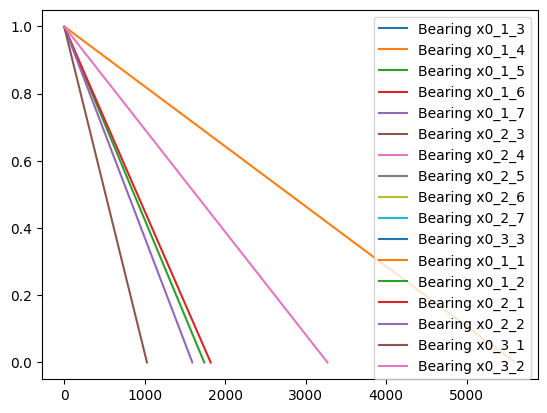

In [107]:
for bearing_id in list(X_test_feature_names) + list(X_train_feature_names):  # Plot first 3 bearings
    plt.plot(y_train[X_train[bearing_id] == 1], label=f'Bearing {bearing_id}')
plt.legend()

In [108]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
y_train = y_train
X_test = scaler.transform(X_test)
y_test = y_test

In [109]:
model = RandomForestRegressor()
xgb_regressory = XGBRegressor(
    n_estimators=300, 
    learning_rate=0.05, 
    max_depth=5,
    objective='reg:squarederror'
)
svr = SVR(kernel='rbf', C=10, gamma='scale')

model.fit(X_train, y_train)
xgb_regressory.fit(X_train, y_train)
svr.fit(X_train, y_train)

SVR(C=10)

In [110]:
def smape(y_true, y_pred):
    denominator = (np.abs(y_true) + np.abs(y_pred))
    # Avoid division by zero (if both y_true and y_pred are zero)
    denominator = np.where(denominator == 0, 1e-10, denominator)
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / denominator)

In [111]:
y_pred = model.predict(X_test)
y_pred_xgb = xgb_regressory.predict(X_test)
y_pred_svr = svr.predict(X_test)

In [112]:
print("Tree")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} seconds")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f}")
print(f"R2: {r2_score(y_test, y_pred):.2f}")
print(f"sMAPE: {smape(y_test, y_pred):.2f}")

print("XGB")
print(f"MAE: {mean_absolute_error(y_test, y_pred_xgb):.2f} seconds")
print(f"MSE: {mean_squared_error(y_test, y_pred_xgb):.2f}")
print(f"R2: {r2_score(y_test, y_pred_xgb):.2f}")
print(f"sMAPE: {smape(y_test, y_pred_xgb):.2f}")

print("SVR")
print(f"MAE: {mean_absolute_error(y_test, y_pred_svr):.2f} seconds")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr):.2f}")
print(f"R2: {r2_score(y_test, y_pred_svr):.2f}")
print(f"sMAPE: {smape(y_test, y_pred_svr):.2f}")

Tree
MAE: 0.19 seconds
MSE: 0.06
R2: 0.10
sMAPE: 37.54
XGB
MAE: 0.17 seconds
MSE: 0.05
R2: 0.21
sMAPE: 34.89
SVR
MAE: 0.26 seconds
MSE: 0.11
R2: -0.77
sMAPE: 42.95
